In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# voy a importar Counter para poder contar los elementos que hayan en la lista de generos
from collections import Counter
from itertools import chain

movies = pd.read_parquet("dataset/movies.parquet")
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45454 entries, 0 to 45465
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               45454 non-null  float64
 1   title            45454 non-null  object 
 2   name_genres      45454 non-null  object 
 3   budget           45454 non-null  float64
 4   revenue          45451 non-null  float64
 5   runtime          45194 non-null  float64
 6   popularity       45451 non-null  float64
 7   name_collection  45454 non-null  object 
 8   vote_count       45451 non-null  float64
 9   vote_average     45451 non-null  float64
 10  status           45370 non-null  object 
 11  overview         44500 non-null  object 
 12  release_year     45368 non-null  float64
dtypes: float64(8), object(5)
memory usage: 4.9+ MB


###
###
###


---

In [3]:
movies.describe()

,id,budget,revenue,runtime,popularity,vote_count,vote_average,release_year
count,45454.000000,4.545400e+04,4.545100e+04,45194.000000,45451.000000,45451.000000,45451.000000,45368.000000
mean,108348.389075,4.225399e+06,1.121157e+07,94.133093,2.921765,109.917538,5.618543,1991.879783
std,112445.975875,1.742576e+07,6.433842e+07,38.406223,6.005910,491.356914,1.924085,24.056453
min,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1874.000000
25%,26447.500000,0.000000e+00,0.000000e+00,85.000000,0.385945,3.000000,5.000000,1978.000000
50%,60004.000000,0.000000e+00,0.000000e+00,95.000000,1.127613,10.000000,6.000000,2001.000000
75%,157304.000000,0.000000e+00,0.000000e+00,107.000000,3.679334,34.000000,6.800000,2010.000000
max,469172.000000,3.800000e+08,2.787965e+09,1256.000000,547.488298,14075.000000,10.000000,2020.000000


- *los percentiles 25, 50 y 75 en budget como en revenue aparecen en 0, estos columnas me dan buena info, gracias a estas puedo suponer cosas como:  
.Que si el presupuesto es alto, fue una super produccion, y por lo tanto es una produccion que se espere sea taquillera  
.Si es bajo, es posible que sea una pelicula del estilo cine independiente, por lo que el publico es mas reducido  
.Mientras que si el revenue es bajo hay una alta probabilidad que al publico no les gusto la pelicula  
.Si es alto, es por que fue bien recibida por los espectadores*  

- *los datos de runtime(duracion de la pelicula en minutos) van desde 0 a 1256, por lo que claramente hay datos que estan mal cargados*

- *vote_average parace tener una distribucion adecuada, una vez grafique me voy a sacar la duda de si hay datos fuera de lo normal*

###
###


---

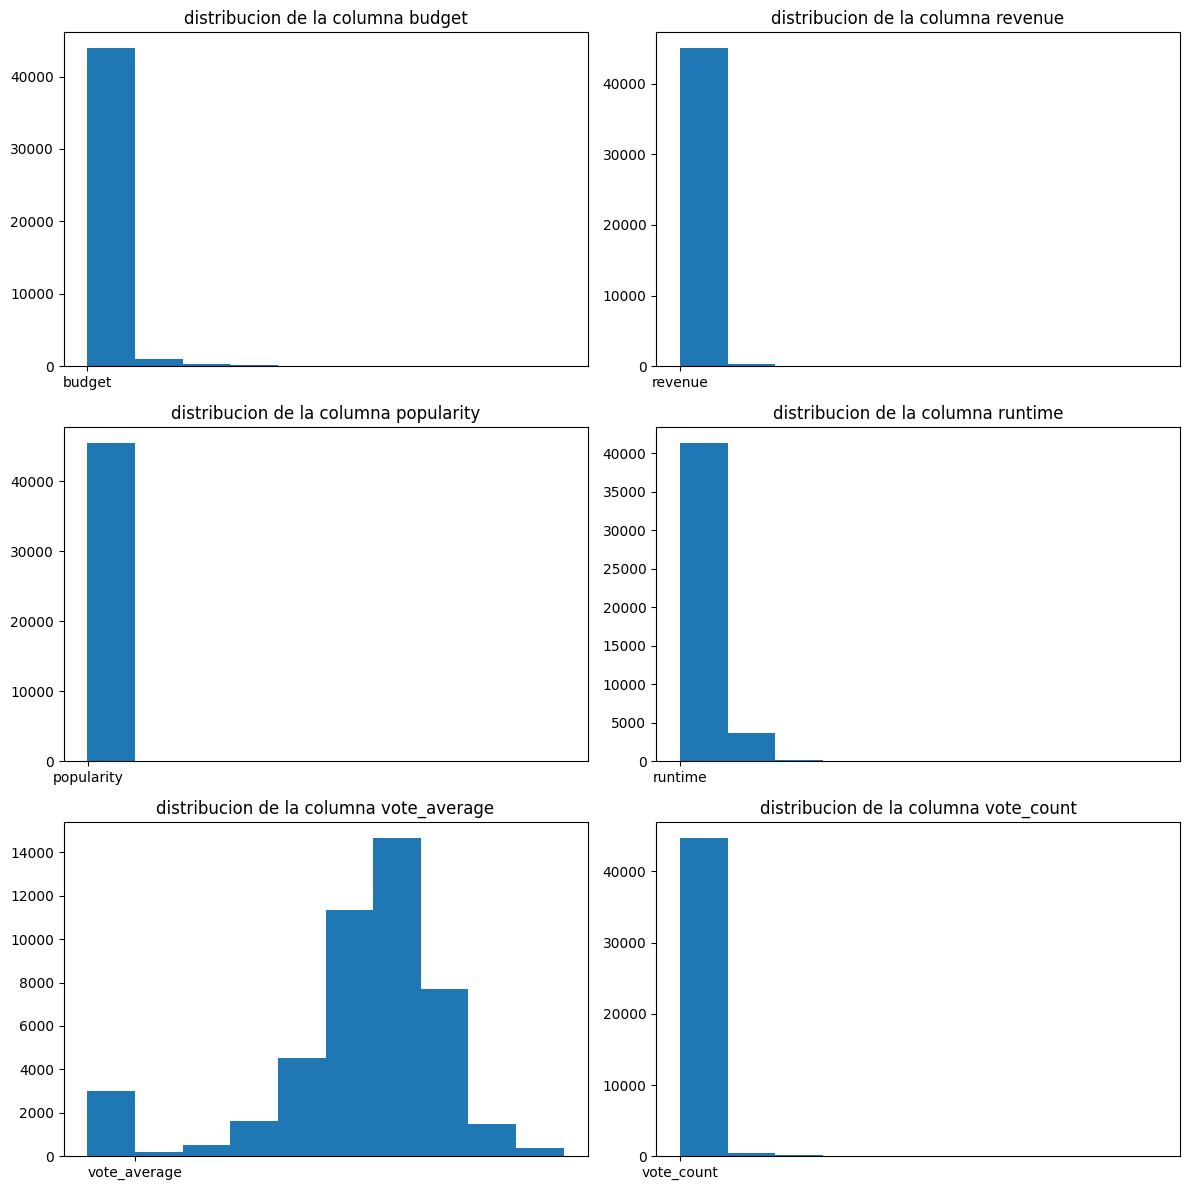

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Define the columns to plot
columns = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count']

# La i va a ser el indice de cada subplot y ax representa la posicion donde se va a graficar este
for i, ax in enumerate(axs.flat):
    column = columns[i]
    ax.hist([movies[column]])
    ax.set_title(f"distribucion de la columna {column}")
    ax.set_xticks([1])
    ax.set_xticklabels([column])

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()

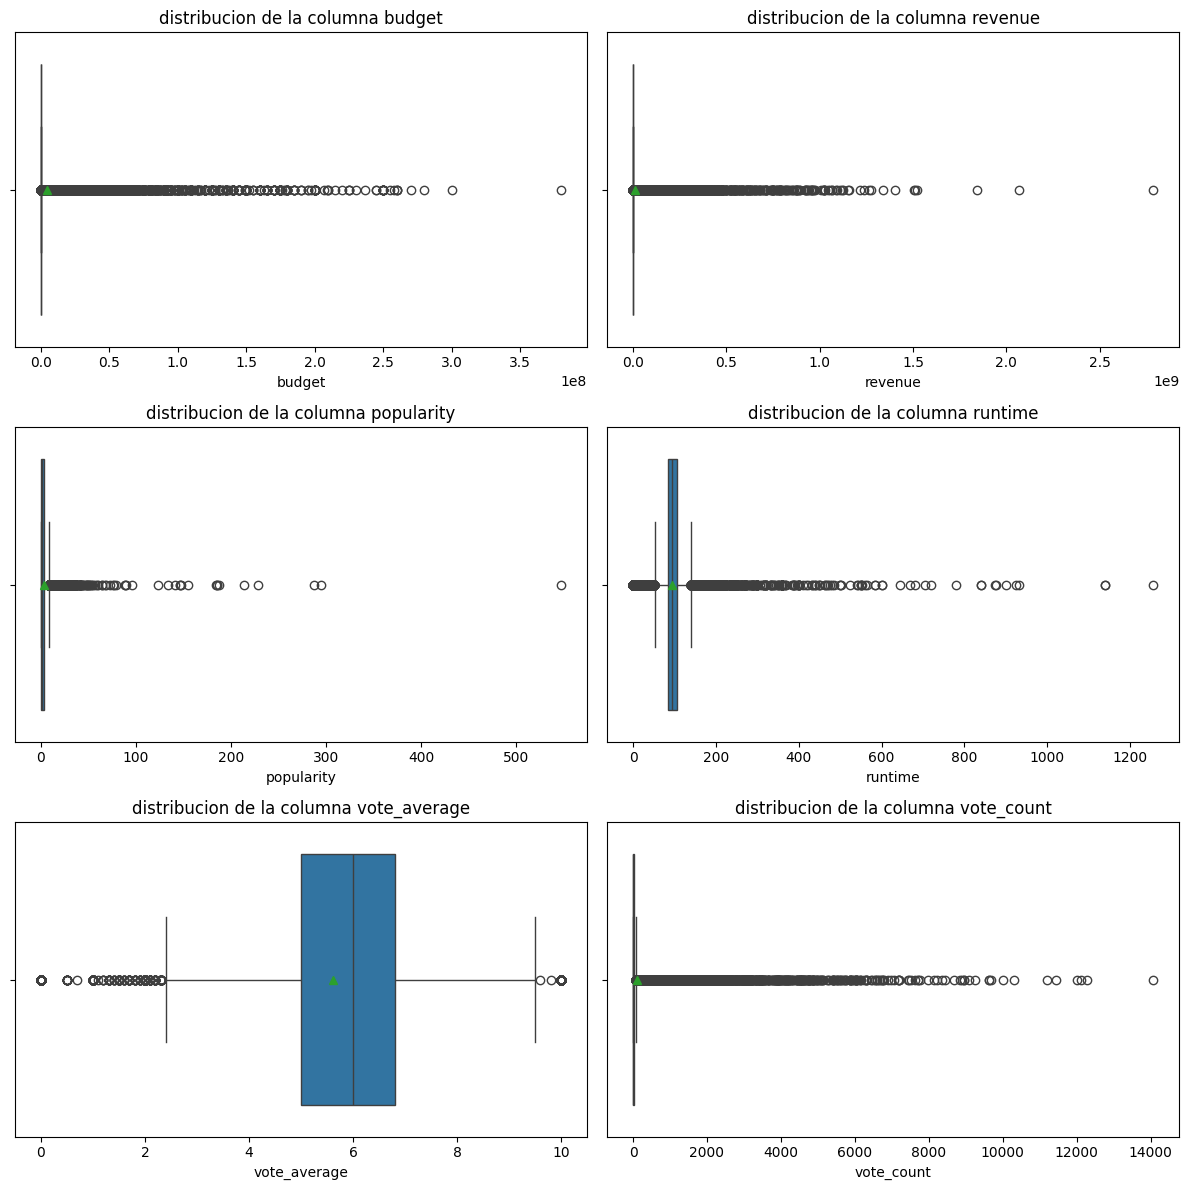

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

columns = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count']

for i, ax in enumerate(axs.flat):
    column = columns[i]
    sns.boxplot(x=movies[column], showmeans=True, ax=ax)
    ax.set_title(f"distribucion de la columna {column}")

fig.tight_layout()

plt.show()

viendo esto me doy la idea que la unica que podria llegar a ser util en la similitud del coseno es vote_average.
Por otro lado, en los histogramas de algunas columnas no se alcanzan a ver los maximos, dandome a entender que no esta muy bien distribuida la data, a eso hay que sumarle que en la representacion grafica de cajas y bigotes tambien tenemos la anomalia de ver que en muchas ni siquiera se forma el cuerpo de la caja. Como diria Arnaldo "Hasta la vista columnas"

###
###
###

*Buscando en la web, encontre que varias de las 'peliculas' que sobresalian de los 240 min(4horas), son peliculas experimentales, y otras cuantas son documentales o series, por lo que, para mejorar el analisis, voy a filtrar solo por las que tengan menos de 240 minutos*

In [6]:
movies = movies[(movies['runtime']<240) & (movies['runtime']!=0)]

In [7]:
movies.runtime.value_counts()

runtime
90.0     2555
100.0    1470
95.0     1412
93.0     1214
96.0     1104
         ... 
233.0       1
232.0       1
211.0       1
222.0       1
227.0       1
Name: count, Length: 235, dtype: int64

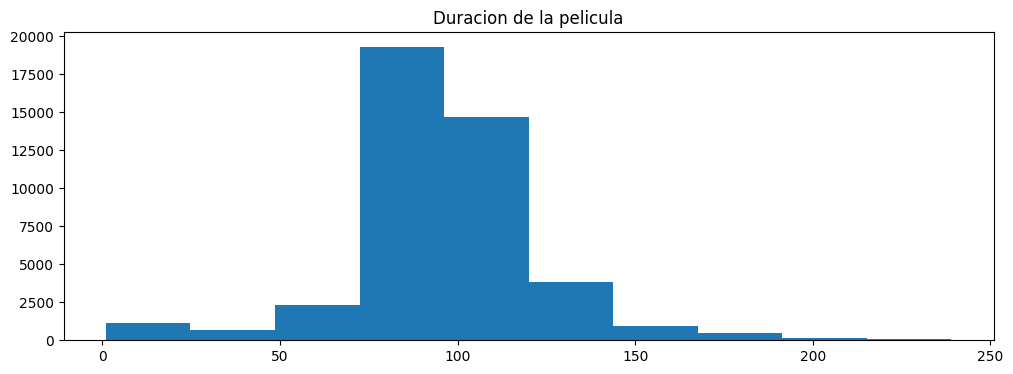

In [8]:
plt.figure(figsize=(12,4))
plt.hist(movies['runtime'])
plt.title("Duracion de la pelicula")
plt.show()

---

In [9]:
movies = movies.drop(['popularity','budget','revenue','vote_count'],axis=1)
movies.head()

,id,title,name_genres,runtime,name_collection,vote_average,status,overview,release_year
0,862.0,Toy Story,"[Animation, Comedy, Family]",81.0,Toy Story,7.7,Released,"Led by Woody, Andy's toys live happily in his ...",1995.0
1,8844.0,Jumanji,"[Adventure, Fantasy, Family]",104.0,0,6.9,Released,When siblings Judy and Peter discover an encha...,1995.0
2,15602.0,Grumpier Old Men,"[Romance, Comedy]",101.0,Grumpy Old Men,6.5,Released,A family wedding reignites the ancient feud be...,1995.0
3,31357.0,Waiting to Exhale,"[Comedy, Drama, Romance]",127.0,0,6.1,Released,"Cheated on, mistreated and stepped on, the wom...",1995.0
4,11862.0,Father of the Bride Part II,[Comedy],106.0,Father of the Bride,5.7,Released,Just when George Banks has recovered from his ...,1995.0


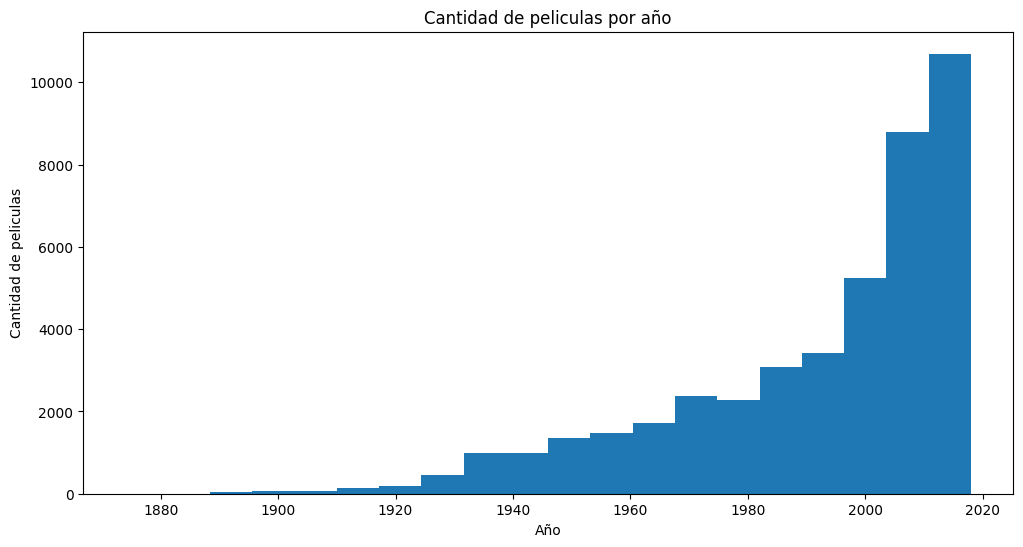

In [10]:
plt.figure(figsize=(12, 6))
plt.hist(movies['release_year'], bins=20)
plt.xlabel('Año')
plt.ylabel('Cantidad de peliculas')
plt.title('Cantidad de peliculas por año')
plt.show()

- Bueno, claramente la industria ha tenido un crecimiento desde sus primeros años, y cada epoca ha tenido un boom o formas de narrar las historias por lo que podria considerar al año como un dato relevante para el entrenamiento
- Sin embargo no lo voy a utilizar ya que el sistema de recomendacion podria priorizar mas aquellas peliculas salidas el mismo año perdiendo recomendaciones de años pasados que son semejantes a estas

###
###


---

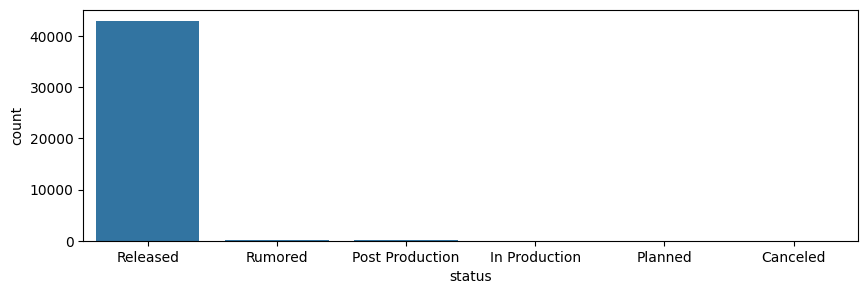

In [11]:
plt.figure(figsize=(10,3))
barras = sns.countplot(data=movies, x='status')
plt.show()

En status hay un par de barritas que tiran como que hubieran peliculas que no fueron estrenadas, voy a separarlas para no estar analizando peliculas que ni siquieran salieron o que solamente se hayan rumoreado

In [12]:
df_filtrado = movies.copy()
df_filtrado = df_filtrado[df_filtrado['status']!='Released']
df_filtrado.head()

,id,title,name_genres,runtime,name_collection,vote_average,status,overview,release_year
189,56088.0,The Show,[Documentary],93.0,0,5.3,None,A documentary about the culture of hip-hop. Th...,1995.0
682,48260.0,Butterfly Kiss,"[Crime, Drama, Romance, Thriller]",88.0,0,7.4,Rumored,Eunice is walking along the highways of northe...,1995.0
767,52059.0,The Gate of Heavenly Peace,[Documentary],180.0,0,6.7,None,The Gate of Heavenly Peace is a feature-length...,1995.0
775,44495.0,A Very Natural Thing,[Drama],80.0,0,6.3,Rumored,"When David, an ex-monk still in his twenties m...",1974.0
1032,38191.0,The Sunchaser,[Drama],122.0,0,6.1,Rumored,A young half-Navajo convict (Jon Seda) dying o...,1996.0


De 3 titulos investigados rapidamente, encontre que: 
- King's road, fue una pelicula estrenada pero diferia en los datos del año  
- Butterfly Kiss tiene dos versiones hechas en 2 paises distintos  
- The Surrender of Tournavos fue una 'corto-mudo' lanzado en 1897
  
voy a hacer la opcion mas facil para evitarme problemas, y filtrar solo por las peliculas que estan etiquetadas como 'Released', el resto, ~~Rumored, Canceled, Post Production, In Production y Planned~~, las voy a eliminar

In [13]:
movies = movies[movies['status']=='Released']


###
###


---

Ahora quiero ver si overview es un dato util o no

In [14]:
# voy a mirar que tipos de overviews se repiten
movies.overview.value_counts()

overview
No overview found.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  122
No Overview                                                                                                                                                                                                                                                                                                                            

In [15]:
# filtro las que se repiten como "No overview..."
resumen = movies[(movies['overview']!='No overview found') & (movies['overview']!='No overview')]
resumen

,id,title,name_genres,runtime,name_collection,vote_average,status,overview,release_year
0,862.0,Toy Story,"[Animation, Comedy, Family]",81.0,Toy Story,7.7,Released,"Led by Woody, Andy's toys live happily in his ...",1995.0
1,8844.0,Jumanji,"[Adventure, Fantasy, Family]",104.0,0,6.9,Released,When siblings Judy and Peter discover an encha...,1995.0
2,15602.0,Grumpier Old Men,"[Romance, Comedy]",101.0,Grumpy Old Men,6.5,Released,A family wedding reignites the ancient feud be...,1995.0
3,31357.0,Waiting to Exhale,"[Comedy, Drama, Romance]",127.0,0,6.1,Released,"Cheated on, mistreated and stepped on, the wom...",1995.0
4,11862.0,Father of the Bride Part II,[Comedy],106.0,Father of the Bride,5.7,Released,Just when George Banks has recovered from his ...,1995.0
...,...,...,...,...,...,...,...,...,...
45460,30840.0,Robin Hood,"[Drama, Action, Romance]",104.0,0,5.7,Released,"Yet another version of the classic epic, with ...",1991.0
45461,439050.0,Subdue,"[Drama, Family]",90.0,0,4.0,Released,Rising and falling between a man and woman.,NaN
45463,67758.0,Betrayal,"[Action, Drama, Thriller]",90.0,0,3.8,Released,"When one of her hits goes wrong, a professiona...",2003.0
45464,227506.0,Satan Triumphant,[],87.0,0,0.0,Released,"In a small town live two brothers, one a minis...",1917.0


In [16]:
nltk.download('stopwords')
# guardamos en una variable los stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/mjb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [18]:
# creo la funcion para eliminar las palabras que se encuentren dentro de las stopwords
def remove_stopwords(text):
    # la siguiente linea se hace para evitar este error en caso de que durante la iteracion se encuentre con un objeto nulo
    # AttributeError: 'NoneType' object has no attribute 'split'
    if text is None or text =='':
        return ''
    #por cada 'PALABRA' dentro del texto 'TEXT' (recortada por cada salto de linea), se anidara en la lista
    # tokens siempre que esta 'PALABRA' no coincida con ninguna palabra dentro de la variable STOP_WORDS
    tokens = [word for word in text.split() if word.lower() not in stop_words]

    return ' '.join(tokens)

In [19]:
resumen['overview'] = resumen['overview'].apply(remove_stopwords)

/tmp/ipykernel_141494/4051368871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resumen['overview'] = resumen['overview'].apply(remove_stopwords)


In [20]:
resumen

,id,title,name_genres,runtime,name_collection,vote_average,status,overview,release_year
0,862.0,Toy Story,"[Animation, Comedy, Family]",81.0,Toy Story,7.7,Released,"Led Woody, Andy's toys live happily room Andy'...",1995.0
1,8844.0,Jumanji,"[Adventure, Fantasy, Family]",104.0,0,6.9,Released,siblings Judy Peter discover enchanted board g...,1995.0
2,15602.0,Grumpier Old Men,"[Romance, Comedy]",101.0,Grumpy Old Men,6.5,Released,family wedding reignites ancient feud next-doo...,1995.0
3,31357.0,Waiting to Exhale,"[Comedy, Drama, Romance]",127.0,0,6.1,Released,"Cheated on, mistreated stepped on, women holdi...",1995.0
4,11862.0,Father of the Bride Part II,[Comedy],106.0,Father of the Bride,5.7,Released,"George Banks recovered daughter's wedding, rec...",1995.0
...,...,...,...,...,...,...,...,...,...
45460,30840.0,Robin Hood,"[Drama, Action, Romance]",104.0,0,5.7,Released,"Yet another version classic epic, enough varia...",1991.0
45461,439050.0,Subdue,"[Drama, Family]",90.0,0,4.0,Released,Rising falling man woman.,NaN
45463,67758.0,Betrayal,"[Action, Drama, Thriller]",90.0,0,3.8,Released,"one hits goes wrong, professional assassin end...",2003.0
45464,227506.0,Satan Triumphant,[],87.0,0,0.0,Released,"small town live two brothers, one minister one...",1917.0


In [21]:
# ahora vamos a unir todas las palabras de la columna OVERVIEW en una sola variable str llamada texto
texto = ' '.join(resumen['overview'])

- finalmente la gran nube de palabras!

In [22]:
# por lo que estuve leyendo wordcloud genera imagenes de baja calidad para acelerar 
#  el procesamiento de grandes cantidades de texto, como esto es aun relativamente
#   una cantidad baja de texto, vamos a aumentar la calidad con el argumento scale=5
word_cloud = WordCloud(scale=5).generate(texto)

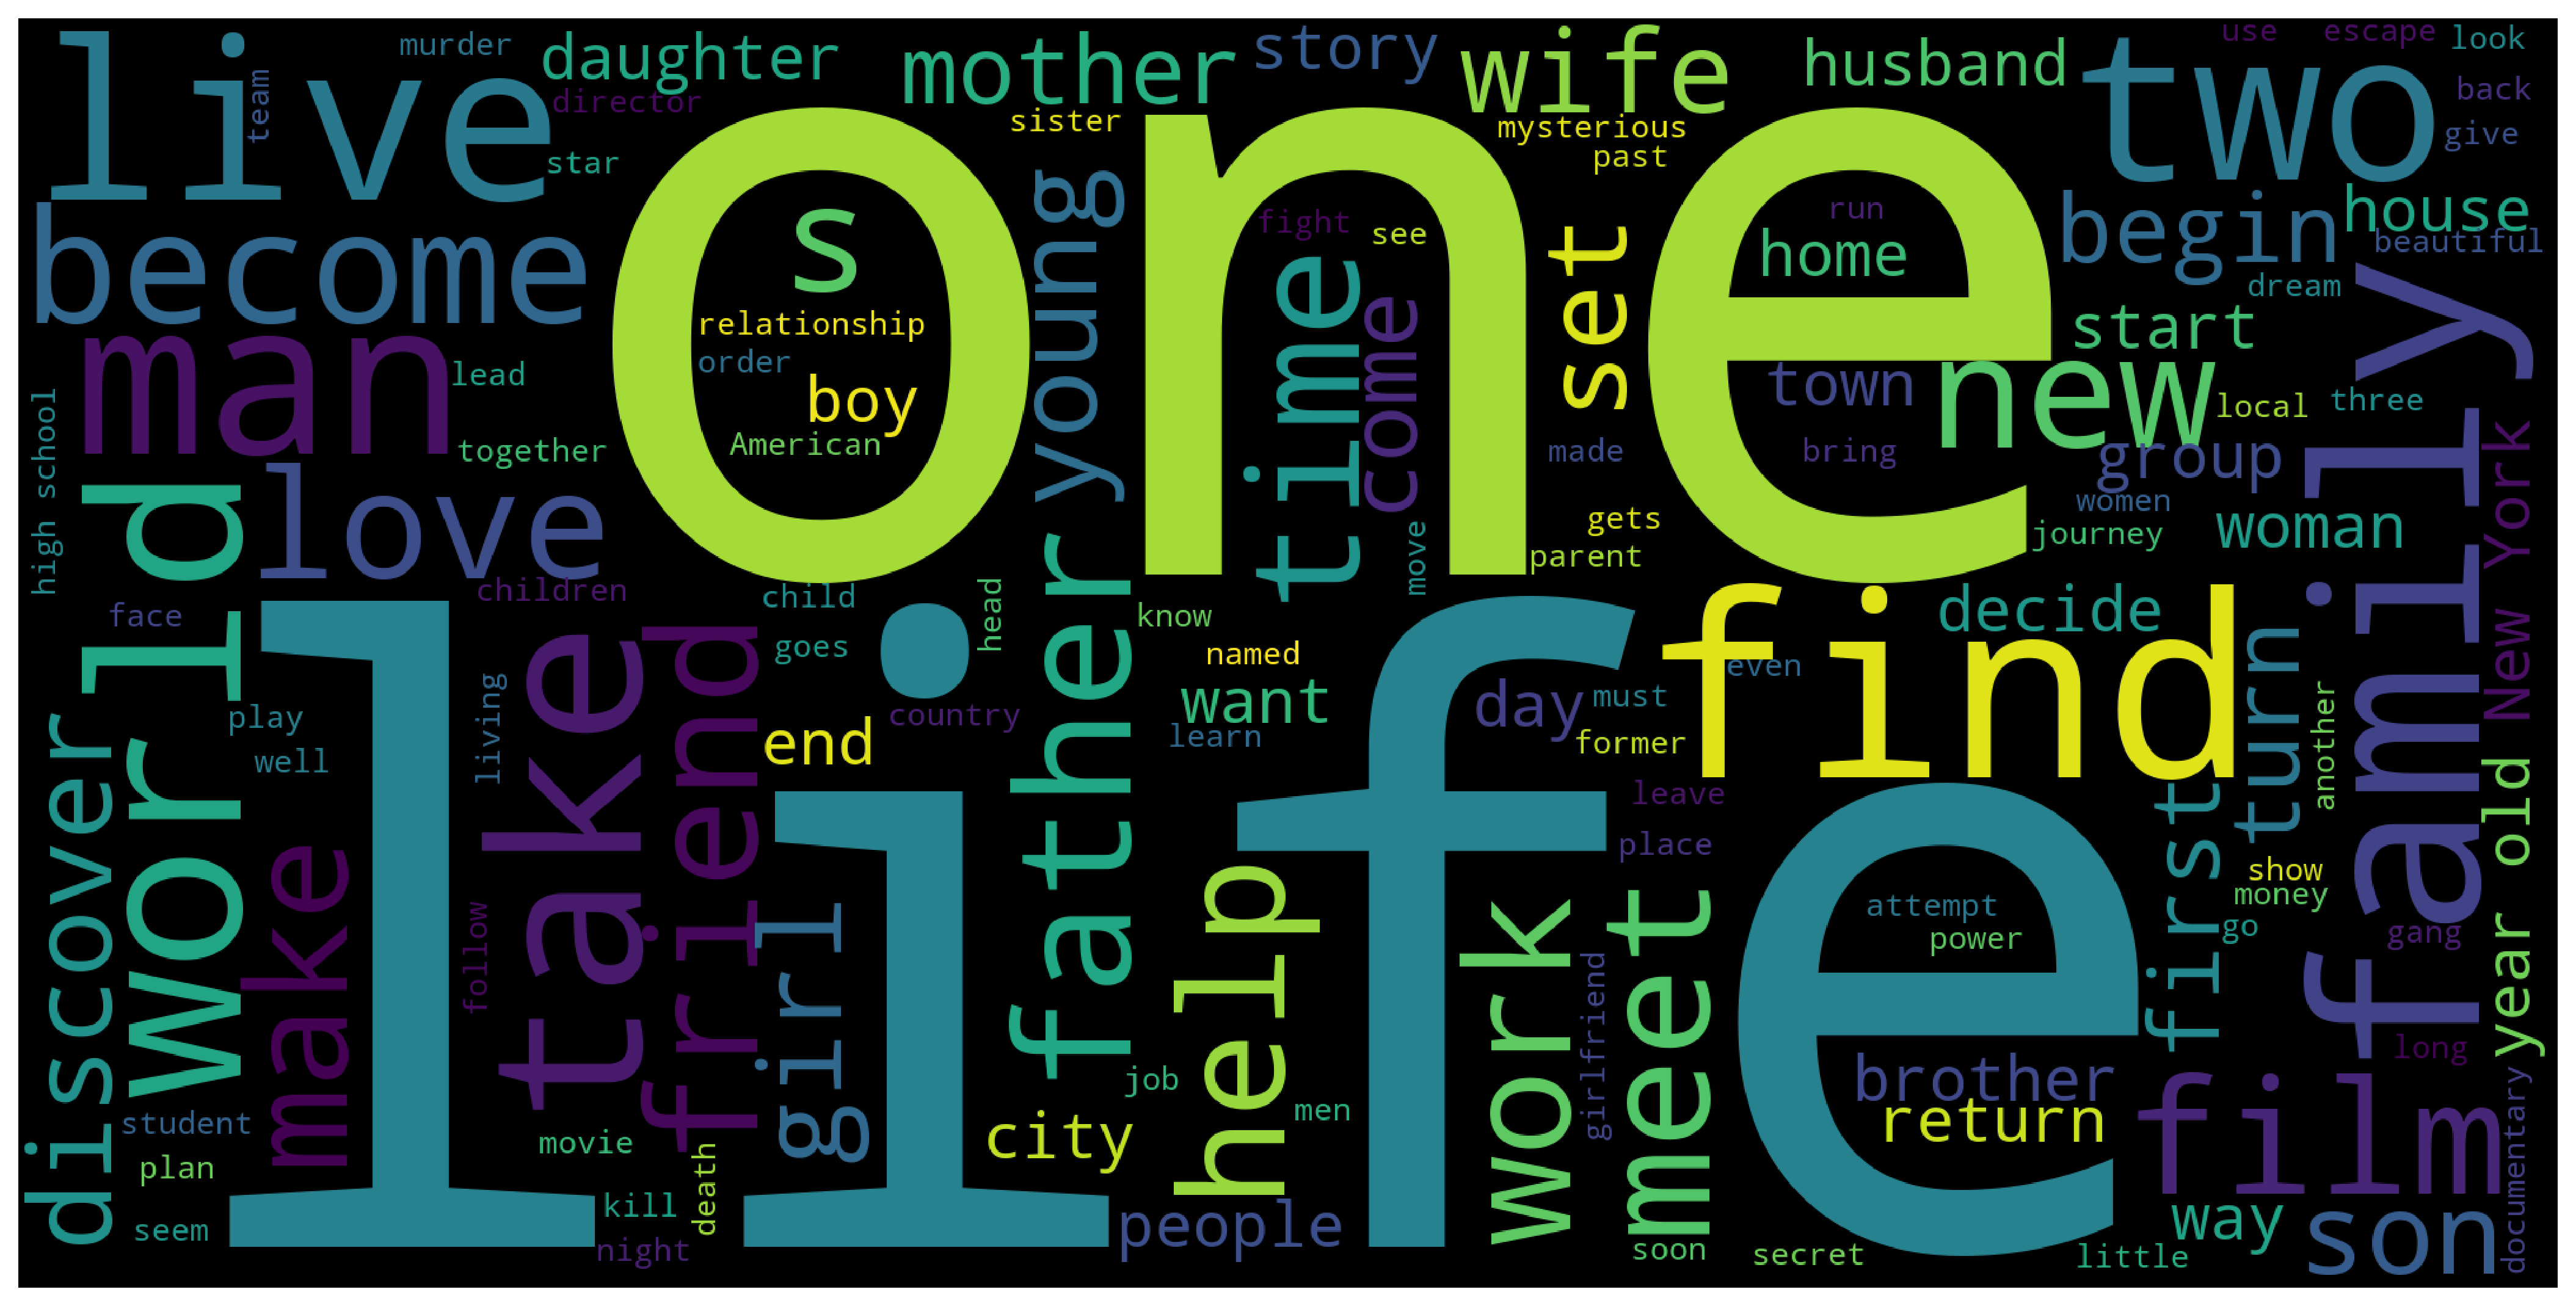

In [23]:
plt.figure(figsize=(18,9), dpi=300)
plt.imshow(word_cloud, interpolation='nearest')
plt.axis('off')
plt.show()

###
###


*life, one, two, family, take, find, live y otras mas siguen siendo palabras muy genericas aun, por lo que no voy a incluir la columna de overview como para definir alguna relacion con las peliculas* ....

###
###


---

limpiamos algunas filas con datos nulos

In [24]:
movies.dropna(inplace=True)

In [25]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42708 entries, 0 to 45465
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               42708 non-null  float64
 1   title            42708 non-null  object 
 2   name_genres      42708 non-null  object 
 3   runtime          42708 non-null  float64
 4   name_collection  42708 non-null  object 
 5   vote_average     42708 non-null  float64
 6   status           42708 non-null  object 
 7   overview         42708 non-null  object 
 8   release_year     42708 non-null  float64
dtypes: float64(4), object(5)
memory usage: 3.3+ MB


###
###
###


---

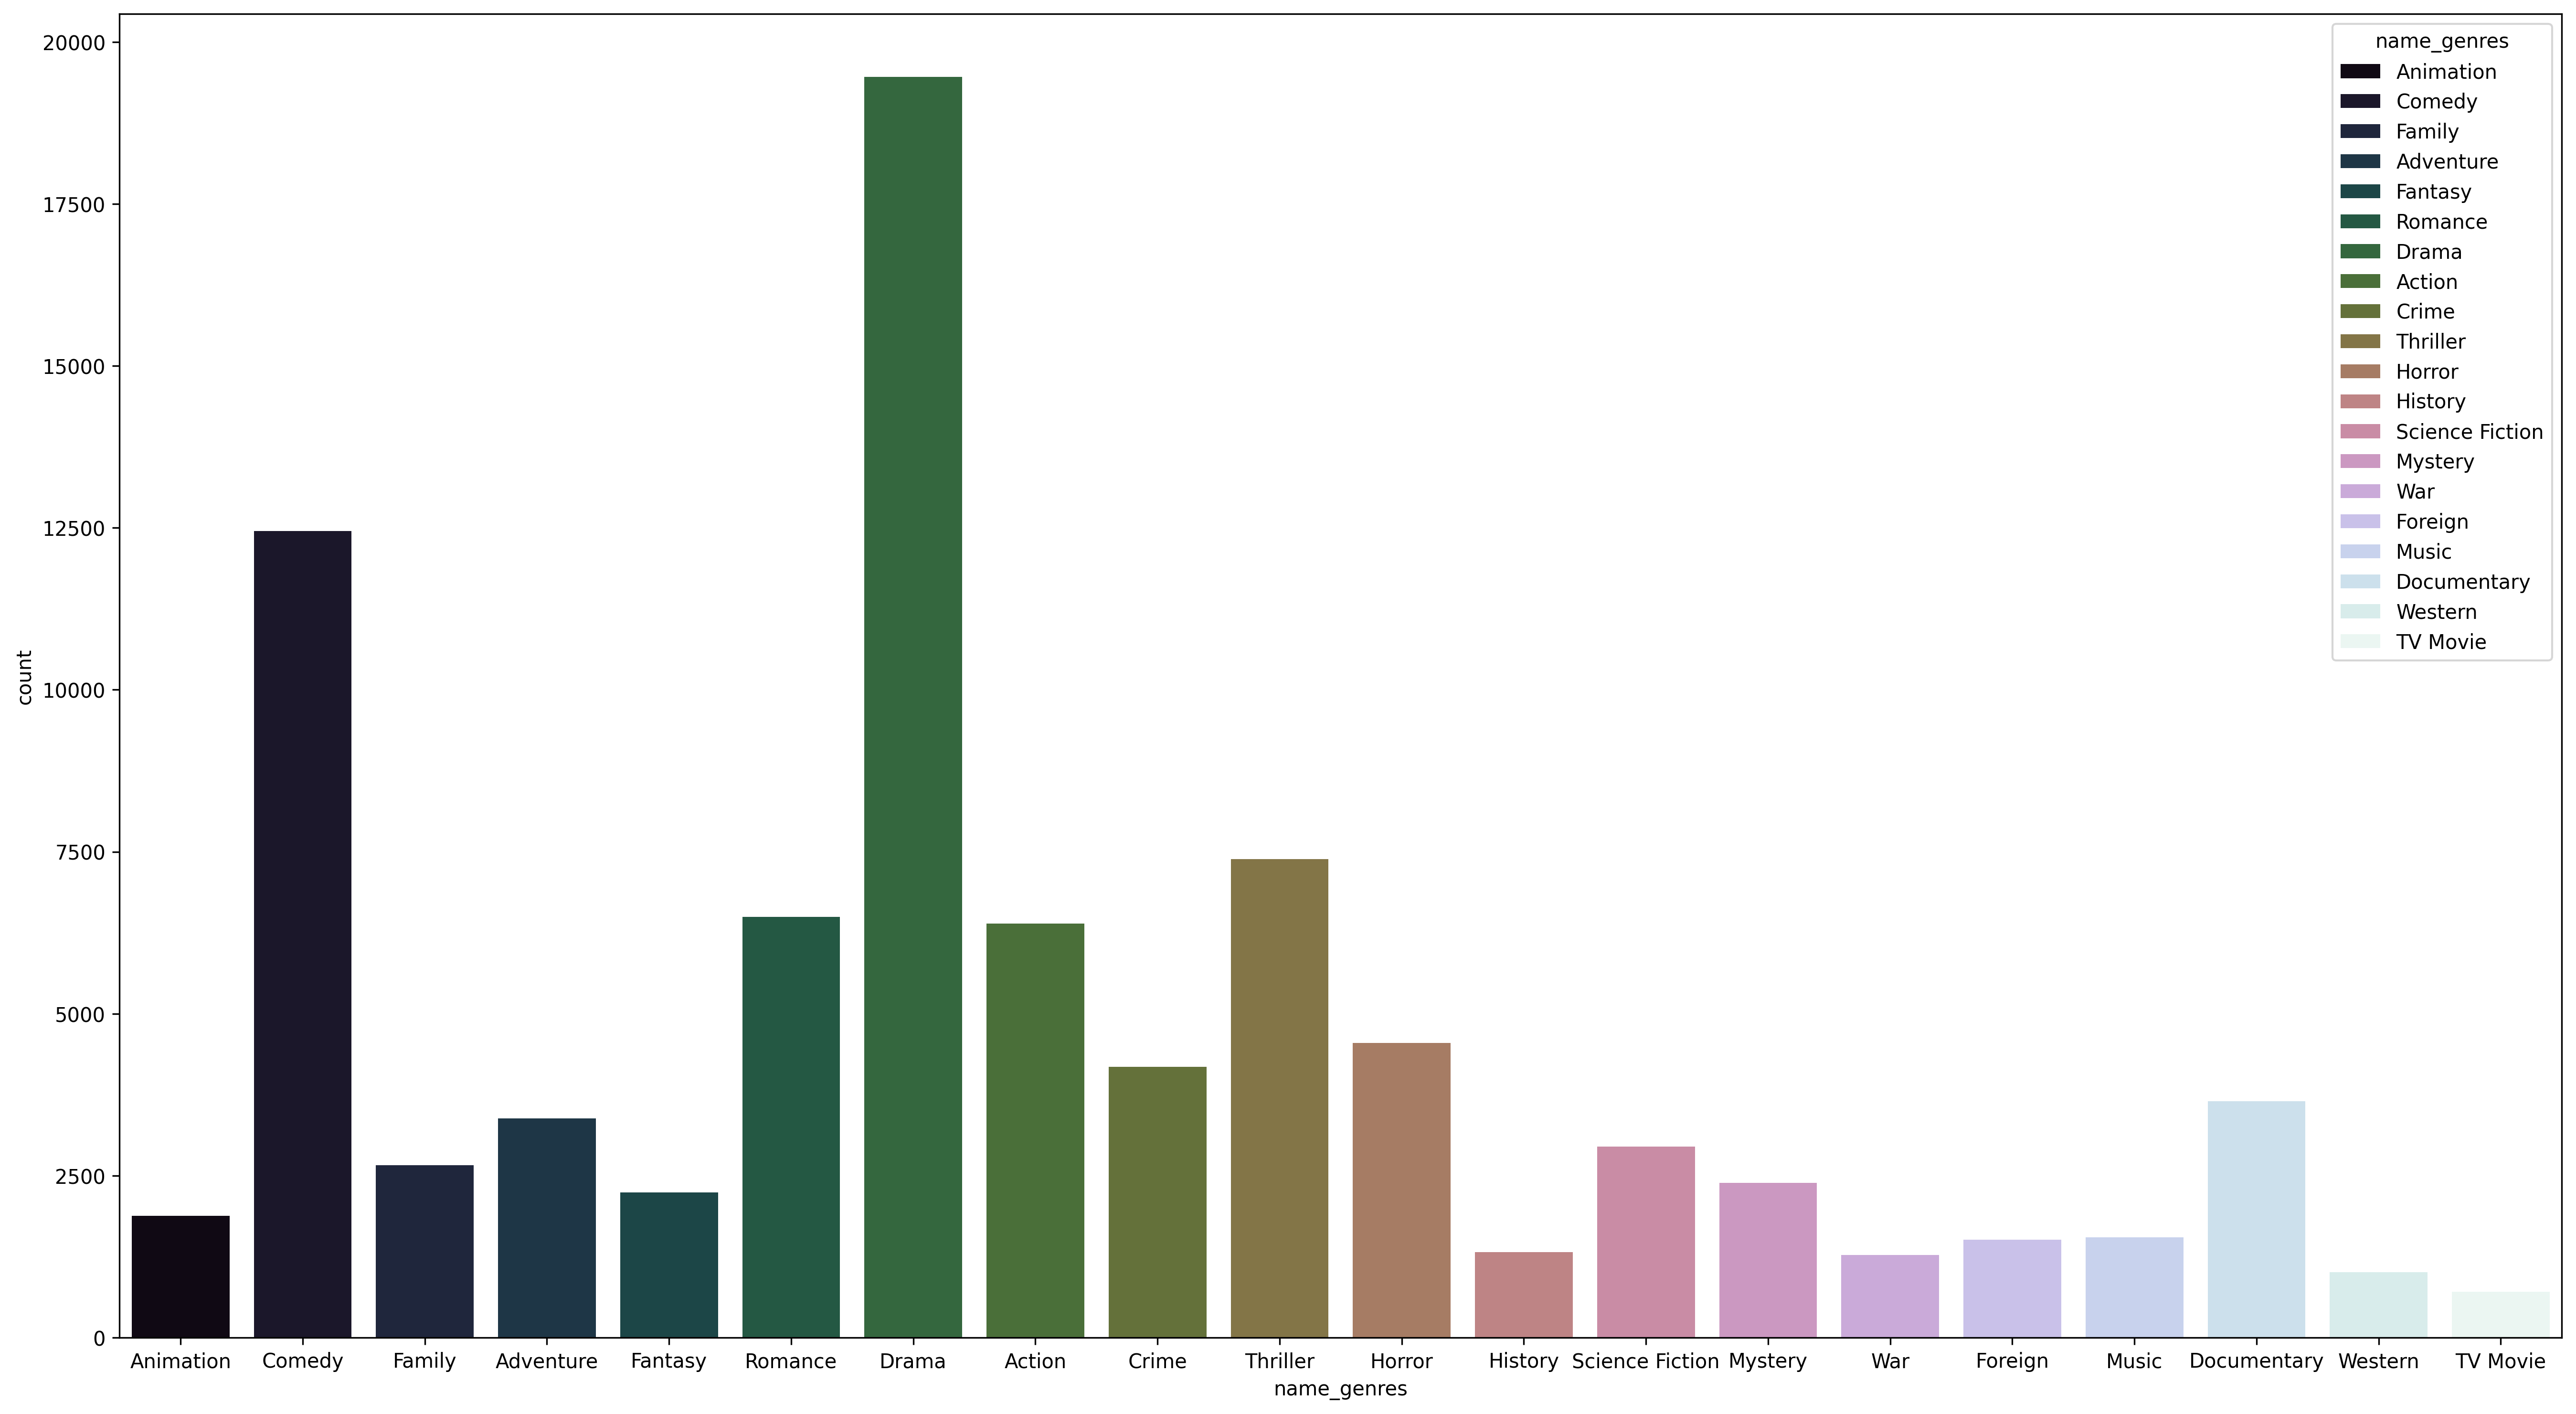

In [26]:
movies_desanidados = movies.explode('name_genres')
movies_desanidados = movies_desanidados.reset_index(drop=True)

plt.figure(figsize=(22,12),dpi=300)
sns.countplot(data=movies_desanidados, x='name_genres', hue='name_genres',palette='cubehelix')
plt.show()

In [27]:
movies_desanidados.name_genres.value_counts()

name_genres
Drama              19459
Comedy             12447
Thriller            7389
Romance             6497
Action              6395
Horror              4548
Crime               4178
Documentary         3649
Adventure           3388
Science Fiction     2947
Family              2659
Mystery             2392
Fantasy             2240
Animation           1883
Music               1548
Foreign             1509
History             1317
War                 1274
Western             1009
TV Movie             706
Name: count, dtype: int64

Con esto ya tengo una idea cuales son los generos dominantes en el cine

*voy a revisar por ultimo la cantidad de generos que tienen las peliculas y cual es su frecuencia*

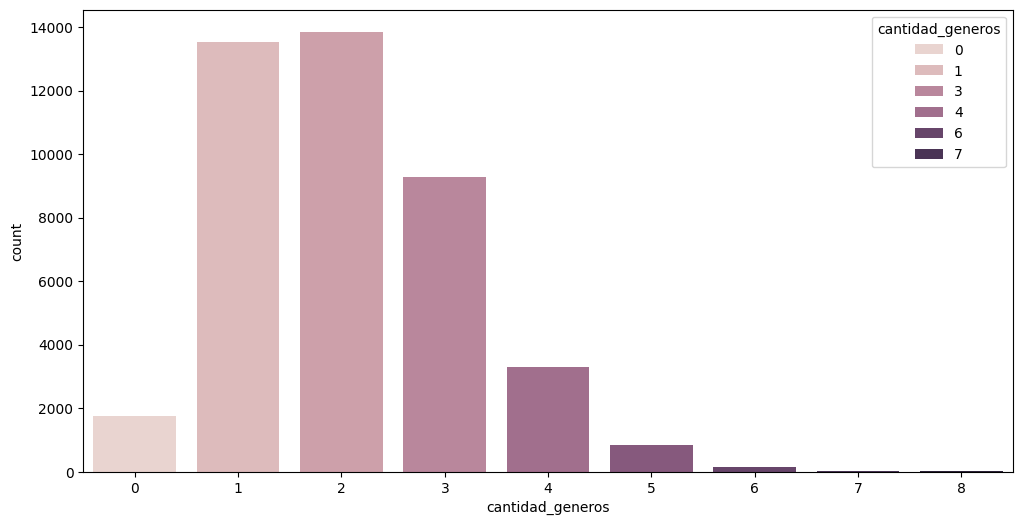

In [28]:
cantidad = movies.copy()

def contar_generos(df):
    df['cantidad_generos'] = df['name_genres'].apply(len)
    return df

contar_generos(cantidad)

plt.figure(figsize=(12,6))
sns.countplot(data=cantidad, x='cantidad_generos', hue='cantidad_generos')
plt.show()

Voy a filtrar un titulo en particular.... y chequear que tantas veces coinciden las ubicaciones de los generos en las listas

In [29]:
ejemplo_generos = movies[movies['title'].str.contains('Terminator')]
ejemplo_generos

,id,title,name_genres,runtime,name_collection,vote_average,status,overview,release_year
582,280.0,Terminator 2: Judgment Day,"[Action, Thriller, Science Fiction]",137.0,The Terminator,7.7,Released,Nearly 10 years have passed since Sarah Connor...,1991.0
1195,218.0,The Terminator,"[Action, Thriller, Science Fiction]",108.0,The Terminator,7.4,Released,"In the post-apocalyptic future, reigning tyran...",1984.0
6388,296.0,Terminator 3: Rise of the Machines,"[Action, Thriller, Science Fiction]",109.0,The Terminator,5.9,Released,It's been 10 years since John Connor saved Ear...,2003.0
13693,534.0,Terminator Salvation,"[Action, Science Fiction, Thriller]",115.0,The Terminator,5.9,Released,"All grown up in post-apocalyptic 2018, John Co...",2009.0
20916,61904.0,Lady Terminator,"[Foreign, Horror, Action]",82.0,0,5.7,Released,The spirit of an ancient evil queen posesses t...,1989.0
25865,87101.0,Terminator Genisys,"[Science Fiction, Action, Thriller, Adventure]",126.0,The Terminator,5.8,Released,"The year is 2029. John Connor, leader of the r...",2015.0
30797,26342.0,The Terminators,"[Action, Horror, Science Fiction]",89.0,0,3.9,Released,A small band of resistance fighters battle the...,2009.0
32057,86223.0,Russian Terminator,[Action],87.0,0,8.0,Released,An ex-mercenary is enlisted back into the life...,1989.0
45000,464819.0,The Making of 'The Terminator': A Retrospective,[Documentary],18.0,0,0.0,Released,An interview session with Arnold Schwarzenegge...,1992.0


**Terminator usualmente tiene el valor Action como primer elemento en la lista y Thriller como segundo**

 ## **Hay muchas peliculas que se clasifican generalmente con 1 o 2  generos, esto me da una idea....**  
 - puedo generar dos columnas con el nombre de genero1 y genero2, esto me va a evitar generar muchisimas columnas(como en el caso de dummies), luego de separar las 2 columnas, las puedo vectorizar por separado


###
###

In [30]:
movies['name_collection'].value_counts()

name_collection
0                                        38362
The Bowery Boys                             28
Zatôichi: The Blind Swordsman               26
James Bond                                  26
The Carry On                                25
                                         ...  
L'allenatore nel pallone - Collezione        1
Bloodfight                                   1
Classmates                                   1
Minions: 3 Mini-Movie                        1
Hooked                                       1
Name: count, Length: 1658, dtype: int64

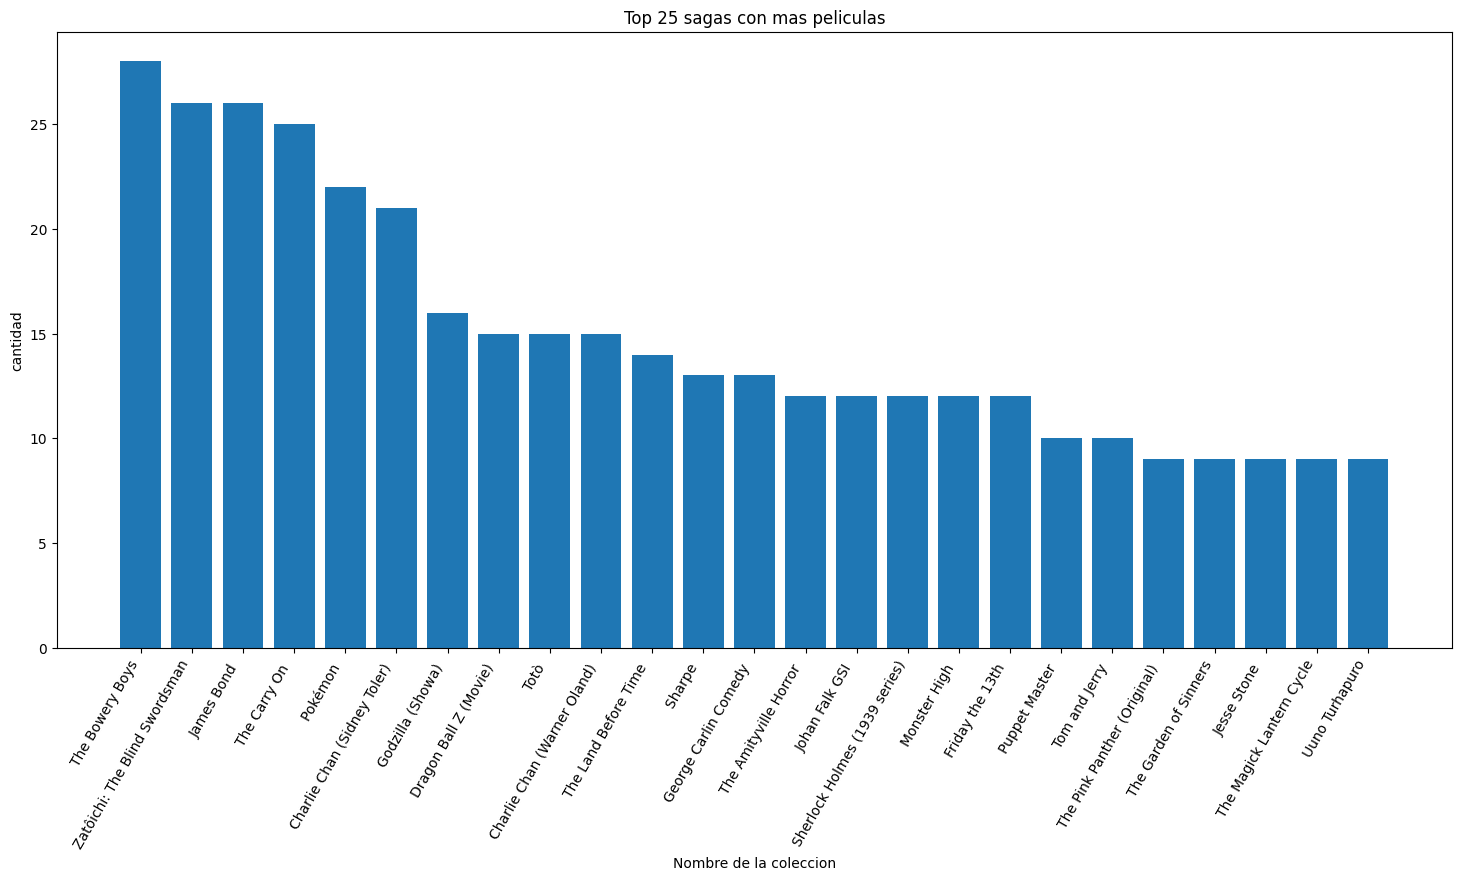

In [31]:
colecciones = movies[movies['name_collection']!='0']
colecciones = colecciones['name_collection'].value_counts().nlargest(25)

plt.figure(figsize=(18,8))
plt.bar(colecciones.index, colecciones.values)
plt.xlabel('Nombre de la coleccion')
plt.xticks(rotation=60, ha='right')
plt.ylabel('cantidad')
plt.title('Top 25 sagas con mas peliculas')
plt.show()

### Finalmente de todas las columnas voy a quedarme con las que le pueden dar un referencia clara al sistema de recomendacion:
- title
- name_collection: la voy a usar para que en caso de tener una secuela, precuela o lo que sea me la recomiende
- genero1: recomendacion de peliculas segun el genero
- genero2: recomendacion de peliculas segun el genero
- vote_average: que recomiende peliculas que tengan la misma o casi igual puntaje
- runtime: que recomiende peliculas de una duracion semejante

###
###


In [32]:
def extract_genres(df_func):
    def extract_genre(row, col_name, idx):
        if idx < len(row['name_genres']):
            return row['name_genres'][idx]
        else:
            return '0'

    df_func['genero1'] = df_func.apply(lambda row: extract_genre(row, 'genero1', 0), axis=1)
    df_func['genero2'] = df_func.apply(lambda row: extract_genre(row, 'genero2', 1), axis=1)
    return df_func

extract_genres(movies)

,id,title,name_genres,runtime,name_collection,vote_average,status,overview,release_year,genero1,genero2
0,862.0,Toy Story,"[Animation, Comedy, Family]",81.0,Toy Story,7.7,Released,"Led by Woody, Andy's toys live happily in his ...",1995.0,Animation,Comedy
1,8844.0,Jumanji,"[Adventure, Fantasy, Family]",104.0,0,6.9,Released,When siblings Judy and Peter discover an encha...,1995.0,Adventure,Fantasy
2,15602.0,Grumpier Old Men,"[Romance, Comedy]",101.0,Grumpy Old Men,6.5,Released,A family wedding reignites the ancient feud be...,1995.0,Romance,Comedy
3,31357.0,Waiting to Exhale,"[Comedy, Drama, Romance]",127.0,0,6.1,Released,"Cheated on, mistreated and stepped on, the wom...",1995.0,Comedy,Drama
4,11862.0,Father of the Bride Part II,[Comedy],106.0,Father of the Bride,5.7,Released,Just when George Banks has recovered from his ...,1995.0,Comedy,0
...,...,...,...,...,...,...,...,...,...,...,...
45459,222848.0,Caged Heat 3000,[Science Fiction],85.0,0,3.5,Released,It's the year 3000 AD. The world's most danger...,1995.0,Science Fiction,0
45460,30840.0,Robin Hood,"[Drama, Action, Romance]",104.0,0,5.7,Released,"Yet another version of the classic epic, with ...",1991.0,Drama,Action
45463,67758.0,Betrayal,"[Action, Drama, Thriller]",90.0,0,3.8,Released,"When one of her hits goes wrong, a professiona...",2003.0,Action,Drama
45464,227506.0,Satan Triumphant,[],87.0,0,0.0,Released,"In a small town live two brothers, one a minis...",1917.0,0,0


por lo tanto vamos a importar estos datos para la consulta del modelo:

In [33]:
movies_final_final = movies[['title','name_collection','runtime','genero1','genero2','vote_average']]

Chequeo que esten en el formato correcto cada uno antes de pasarlo a Parquet

In [34]:
movies_final_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42708 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            42708 non-null  object 
 1   name_collection  42708 non-null  object 
 2   runtime          42708 non-null  float64
 3   genero1          42708 non-null  object 
 4   genero2          42708 non-null  object 
 5   vote_average     42708 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.3+ MB


In [35]:
movies_final_final.head()

,title,name_collection,runtime,genero1,genero2,vote_average
0,Toy Story,Toy Story,81.0,Animation,Comedy,7.7
1,Jumanji,0,104.0,Adventure,Fantasy,6.9
2,Grumpier Old Men,Grumpy Old Men,101.0,Romance,Comedy,6.5
3,Waiting to Exhale,0,127.0,Comedy,Drama,6.1
4,Father of the Bride Part II,Father of the Bride,106.0,Comedy,0,5.7


In [36]:
movies_final_final.to_parquet("../consultas/consultas_ml")

---

---

---